<a href="https://colab.research.google.com/github/Mostafa-wael/U-Net-in-PyTorch/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net
This is an implementation of the U-Net model from the paper, [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://papers.labml.ai/paper/1505.04597).

U-Net is made up of a contracting path and an expanding path.
The contracting route is a series of convolutional layers and pooling layers that gradually diminish the resolution of the feature map.
The expansive route is a succession of up-sampling and convolutional layers that gradually enhance the resolution of the feature map.

The relevant feature map from the contracting path is concatenated with the current feature map at each step in the expansive path.

# Implementation 1
Adapted from [here](https://nn.labml.ai/unet/index.html).

In [1]:
import torch
import torchvision.transforms.functional
from torch import nn

### Two $3 \times 3$ Convolution Layers

Each step in the contraction path and expansive path have two $3 \times 3$
convolutional layers followed by ReLU activations.

In the U-Net paper they used $0$ padding,
but we use $1$ padding so that final feature map is not cropped.

In [2]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # First 3x3 convolutional layer
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        # Second 3x3 convolutional layer
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        # Apply the two convolution layers and activations
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)

  ### Down-sample

  Each step in the contracting path down-samples the feature map with
  a $2 \times 2$ max pooling layer.

In [3]:
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        # Max pooling layer
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor):
        return self.pool(x)

  ### Up-sample

  Each step in the expansive path up-samples the feature map with
  a $2 \times 2$ up-convolution.

In [6]:
class UpSample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Up-convolution
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor):
        return self.up(x)

  ### Crop and Concatenate the feature map

  At every step in the expansive path the corresponding feature map from the contracting path
  concatenated with the current feature map.
  

In [7]:
class CropAndConcat(nn.Module):
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        # Crop the feature map from the contracting path to the size of the current feature map
        contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[2], x.shape[3]])
        # Concatenate the feature maps
        x = torch.cat([x, contracting_x], dim=1)
        return x

## U-Net


In [8]:
class UNet(nn.Module):
    def __init__(self, out_channels: int):

        super().__init__()
        # Double convolution layers for the contracting path.
        # The number of features gets doubled at each step starting from 64.
        down_conv_sizes = [(3, 64), (64, 128), (128, 256), (256, 512)]
        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in down_conv_sizes])
        
        # Down sampling layers for the contracting path
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])

        # The two convolution layers at the lowest resolution (the bottom of the U).
        self.middle_conv = DoubleConvolution(512, 1024)

        # Up sampling layers for the expansive path.
        # The number of features is halved with up-sampling.
        upsample_sizes = [(1024, 512), (512, 256), (256, 128), (128, 64)]
        
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in upsample_sizes])
        # Double convolution layers for the expansive path.
        # Their input is the concatenation of the current feature map and the feature map from the
        # contracting path. Therefore, the number of input features is double the number of features
        # from up-sampling.
        up_conv_sizes = [(1024, 512), (512, 256), (256, 128), (128, 64)]
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in up_conv_sizes])
        
        # Crop and concatenate layers for the expansive path.
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
        
        # Final 1x1 convolution layer to produce the output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        # To collect the outputs of contracting path for later concatenation with the expansive path.
        pass_through = []
        # Contracting path
        for i in range(len(self.down_conv)):
            # Two 3x3 convolutional layers
            x = self.down_conv[i](x)
            # Collect the output
            pass_through.append(x)
            # Down-sample
            x = self.down_sample[i](x)

        # Two 3x3 convolutional layers at the bottom of the U-Net
        x = self.middle_conv(x)

        # Expansive path
        for i in range(len(self.up_conv)):
            # Up-sample
            x = self.up_sample[i](x)
            # Concatenate the output of the contracting path
            x = self.concat[i](x, pass_through.pop())
            # Two 3x3 convolutional layers
            x = self.up_conv[i](x)

        # Final 1x1 convolution layer
        out = self.final_conv(x)

        return out


True
Epoch 0/59
----------
LR 0.0001


/home/toldo/miniconda3/envs/rai_py38_poetry_enn/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: bce: 0.692980, dice: 0.990522, loss: 0.841751
val: bce: 0.686773, dice: 0.990550, loss: 0.838661
saving best model
0m 2s
Epoch 1/59
----------
LR 0.0001
train: bce: 0.683768, dice: 0.990555, loss: 0.837162
val: bce: 0.677781, dice: 0.990577, loss: 0.834179
saving best model
0m 1s
Epoch 2/59
----------
LR 0.0001
train: bce: 0.672591, dice: 0.990585, loss: 0.831588
val: bce: 0.662046, dice: 0.990614, loss: 0.826330
saving best model
0m 1s
Epoch 3/59
----------
LR 0.0001
train: bce: 0.652779, dice: 0.990643, loss: 0.821711
val: bce: 0.633069, dice: 0.990697, loss: 0.811883
saving best model
0m 1s
Epoch 4/59
----------
LR 0.0001
train: bce: 0.613748, dice: 0.990767, loss: 0.802257
val: bce: 0.570919, dice: 0.990931, loss: 0.780925
saving best model
0m 1s
Epoch 5/59
----------
LR 0.0001
train: bce: 0.518764, dice: 0.991245, loss: 0.755004
val: bce: 0.374296, dice: 0.992263, loss: 0.683279
saving best model
0m 1s
Epoch 6/59
----------
LR 0.0001
train: bce: 0.204075, dice: 0.995039, lo

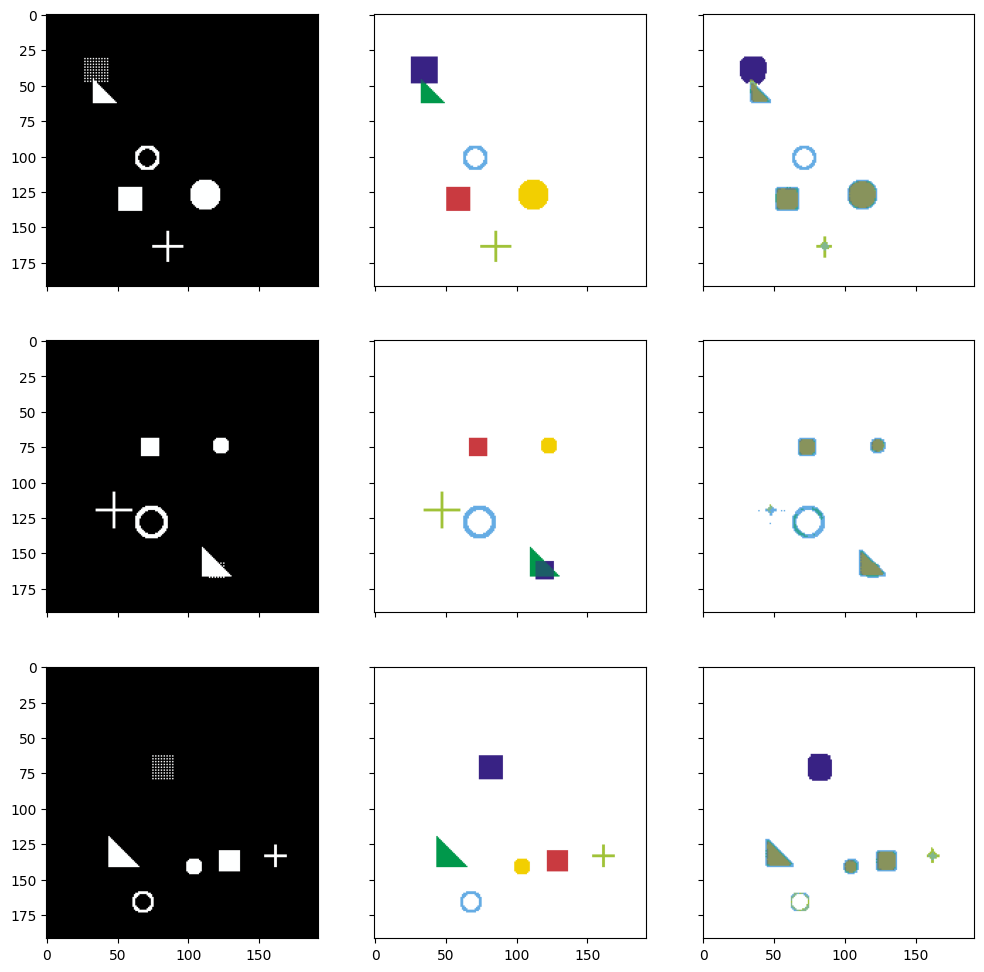

In [9]:
import test_u_net

test_u_net.run(UNet)

# Implementation 2
More simple and strightforward 

In [10]:
# First, the necessary modules are imported from the torch and torchvision packages, including the nn module for building neural networks and the pre-trained models provided in torchvision.models. 
# The relu function is also imported from torch.nn.functional.
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu


# Then, a custom class UNet is defined as a subclass of nn.Module. 
# The __init__ method initializes the architecture of the U-Net by defining the layers for both the encoder and decoder parts of the network. 
# The argument n_class specifies the number of classes for the segmentation task.
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        # In the decoder, transpose convolutional layers with the ConvTranspose2d function are used to upsample the feature maps to the original size of the input image. 
        # Each block in the decoder consists of an upsampling layer, a concatenation with the corresponding encoder feature map, and two convolutional layers.
        # -------
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out


True
Epoch 0/59
----------
LR 0.0001
train: bce: 0.700378, dice: 0.990332, loss: 0.845355
val: bce: 0.691634, dice: 0.990553, loss: 0.841094
saving best model
0m 1s
Epoch 1/59
----------
LR 0.0001
train: bce: 0.687530, dice: 0.990310, loss: 0.838920
val: bce: 0.680313, dice: 0.990540, loss: 0.835427
saving best model
0m 1s
Epoch 2/59
----------
LR 0.0001
train: bce: 0.674767, dice: 0.990306, loss: 0.832536
val: bce: 0.663694, dice: 0.990543, loss: 0.827118
saving best model
0m 1s
Epoch 3/59
----------
LR 0.0001
train: bce: 0.653411, dice: 0.990317, loss: 0.821864
val: bce: 0.631499, dice: 0.990552, loss: 0.811026
saving best model
0m 1s
Epoch 4/59
----------
LR 0.0001
train: bce: 0.609988, dice: 0.990354, loss: 0.800171
val: bce: 0.560475, dice: 0.990654, loss: 0.775565
saving best model
0m 1s
Epoch 5/59
----------
LR 0.0001
train: bce: 0.498802, dice: 0.990658, loss: 0.744730
val: bce: 0.332863, dice: 0.991727, loss: 0.662295
saving best model
0m 1s
Epoch 6/59
----------
LR 0.0001
tr

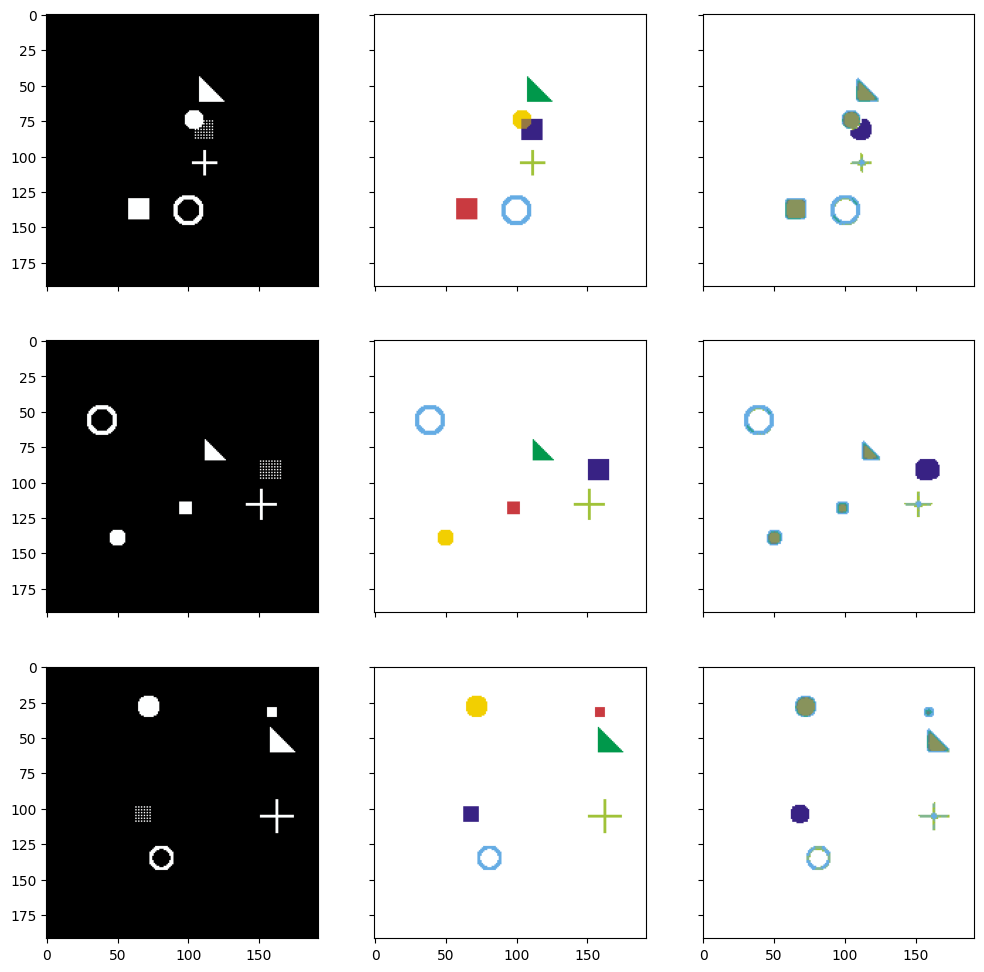

In [17]:
import test_u_net

test_u_net.run(UNet)